In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab

import numpy as np
import os

from astropy.time import Time
from matplotlib import gridspec

from IPython.display import display
from ipywidgets import interact, widgets

In [2]:
#input_file = widgets.Text(value='data/oh3573s2_blue_red_channels.ts',
input_file = widgets.Text(value='data/vmic_blue_red_channels.tscatJD',
                          placeholder='Type full path to HartRAO data file here',
                          description='filename:',
                          disabled=False,
                          layout={'width':'405px'},
                         )
#input_tsfmt = widgets.Dropdown(value='jd',
input_tsfmt = widgets.Dropdown(value='mjd',
                               options=['mjd', 'jd'],
                               description='JD format:',
                               disabled=False,
                               layout={'width':'200px'},
                              )
#input_epoch = widgets.Text(value='2440000',
input_epoch = widgets.Text(value='0',
                           placeholder='epoch',
                           description='epoch:',
                           disabled=False,
                           layout={'width':'200px'},
                          )
options = widgets.HBox([input_tsfmt, input_epoch])
ui = widgets.VBox([input_file, options])
display(ui)

VkJveChjaGlsZHJlbj0oVGV4dCh2YWx1ZT11J2RhdGEvdm1pY19ibHVlX3JlZF9jaGFubmVscy50c2NhdEpEJywgZGVzY3JpcHRpb249dSdmaWxlbmFtZTonLCBsYXlvdXQ9TGF5b3V0KHdpZHTigKY=


In [3]:
filename = input_file.value
tsformat = input_tsfmt.value
epoch = float(input_epoch.value)
print("Reading OH monitoring file {} using epoch {} and '{}' format for time interpretation".
      format(filename, epoch, tsformat.upper()))

Reading OH monitoring file data/vmic_blue_red_channels.tscatJD using epoch 0.0 and 'MJD' format for time interpretation


In [4]:
import hart_io as io
# read input data assuming HartRAO format
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(filename,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)

In [5]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')
[nts, nch] = spectra.shape

VMIC         OH1612 time series of intensities F from vmic.sf85
MJD, -4.072, 7.085

Spectral data size (#ts, #ch) = (157, 2)


In [6]:
import detrend

def find_polyorder(xdata, ydata, npoly=3, verbose=False):
    
    poly_range = range(1,npoly+1)
    
    means = []
    plus_sigma = []
    neg_sigma = []
    report = 'npoly \t mean \t\t std<0 \t\t std>0 \n'
    for poly_order in poly_range:
        ffit = detrend.polyfit(xdata, ydata, poly_order)
        detrended_flux = ydata - ffit(xdata)
    
        means.append(np.mean(detrended_flux))
        plus_sigma.append(np.std(detrended_flux[detrended_flux>0]))
        neg_sigma.append(np.std(detrended_flux[detrended_flux<0]))
        report += '{} \t {:.3e} \t {:.4f} \t {:.4f} \n'.format(poly_order,
                                                               means[-1],
                                                               neg_sigma[-1],
                                                               plus_sigma[-1])

    if verbose: print(report)
    sigma_diff = np.abs(np.array(plus_sigma)-np.array(neg_sigma))
    return poly_range[np.argmin(sigma_diff)]

npoly 	 mean 		 std<0 		 std>0 
1 	 3.666e-15 	 0.4330 	 0.4777 

npoly 	 mean 		 std<0 		 std>0 
1 	 8.599e-16 	 0.3980 	 0.4163 



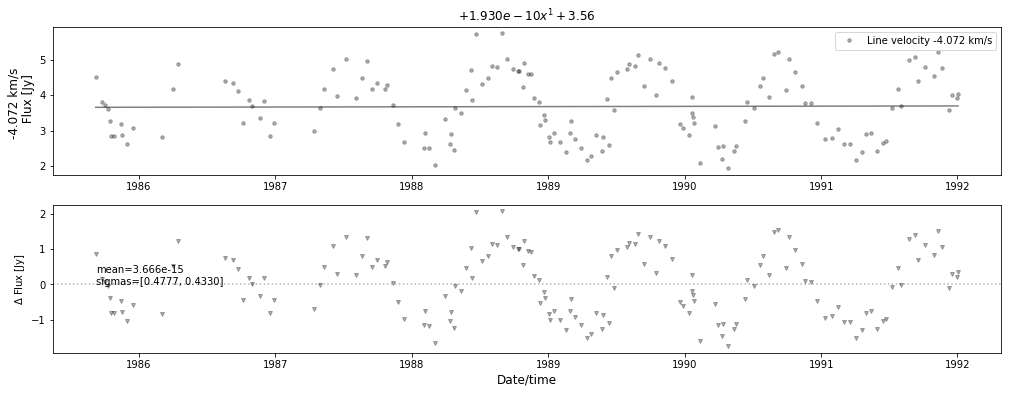

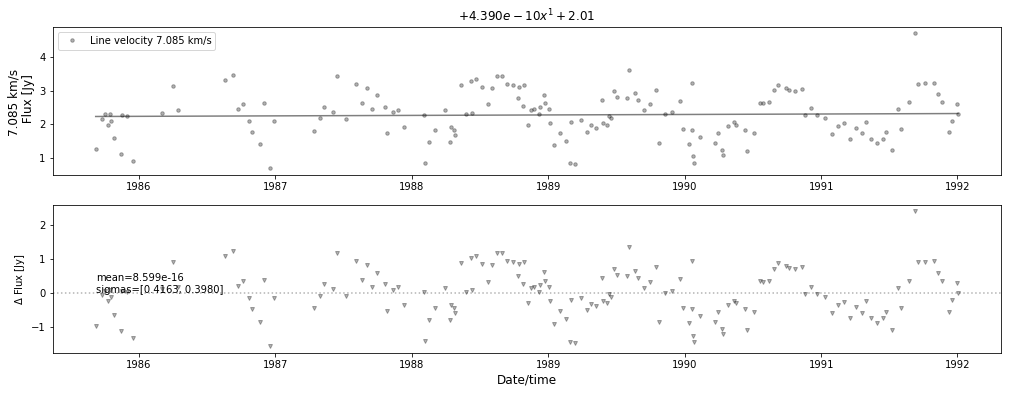

In [7]:
def sign(x):
    if x < 0: return '-'
    else: return '+'

fig_name = os.path.splitext(os.path.basename(filename))[0].split('_')[0]
velocity = {0: 'blue', 1: 'red'}

detrended_spectra = []
for channel in range(nch):
    flux = spectra[:, channel]
    poly_order = find_polyorder(ts_jd.unix,
                                flux,
                                npoly=1, verbose=True)
    
    ffit = detrend.polyfit(ts_jd.unix, flux, poly_order)
    detrended_flux = flux - ffit(ts_jd.unix)
    
    fig= plt.subplots(figsize=(17,6),
                      facecolor='white')
    gs = gridspec.GridSpec(2, 1)
    ax0 = plt.subplot(gs[0])
    ax0.plot(ts_jd.datetime, flux,
             color='k', marker='.', linestyle='none', markersize=7, alpha=0.3,
             label=r'Line velocity {} km/s'.format(chan_vel[channel]))
    ax0.plot(ts_jd.datetime, ffit(ts_jd.unix),
             color='k', marker=',', linestyle='-', markersize=0, alpha=0.5)
    ax0.legend(loc=0)
    ax0.set_ylabel('{} km/s \n Flux [Jy]'.format(chan_vel[channel]), fontsize=12)
    title = ''
    coeffs = ffit.coeffs[:-1]
    for cnt, coeff in enumerate(coeffs):
        title += ' {} {:.3e} x^{}'.format(sign(coeff), abs(coeff), len(coeffs)-cnt)
    title+=' {} {:.2f}'.format(sign(ffit.coeffs[-1]), abs(ffit.coeffs[-1]))
    ax0.set_title(r'$%s$' % title)
        
    ax1 = plt.subplot(gs[1])
    ax1.plot(ts_jd.datetime, detrended_flux,
             color='k', marker='v', linestyle='none', markersize=4, alpha=0.3)
    ax1.axhline(y=0, color='k', linestyle=':', alpha=0.3)
    ax1.set_xlabel('Time [Yrs]')
    ax1.set_ylabel(r'$\Delta$ Flux [Jy]')
    ax1.set_xlabel('Date/time', fontsize=12)
    mean = np.mean(detrended_flux)
    plus_sigma = np.std(detrended_flux[detrended_flux>0])
    neg_sigma = np.std(detrended_flux[detrended_flux<0])
    anno_text = 'mean={:.3e}\nsigmas=[{:.4f}, {:.4f}]'.format(mean, plus_sigma, neg_sigma)
    style = dict(size=10, color='black')
    ax1.text(ts_jd.datetime[0], 0, anno_text, **style)
    
    im_name = '{}_{}_channel_detrend.png'.format(fig_name, velocity[channel])
    plt.savefig(im_name, bbox_inches='tight')
    
    if len(detrended_spectra) < 1:
        detrended_spectra = detrended_flux
    else:
        detrended_spectra = np.vstack([detrended_spectra, detrended_flux])
        
plt.show()

Cleaned data (dots) show a long term trend over time, which is easily removed by subtracting a low order polynomial

In [8]:
def timeseries(xdata, ydata,
               label=None, color='k', marker='.', linestyle=':', alpha=1.,
               fig=None, ax=None,
               ):
    if ax is None:
        fig = plt.subplots(figsize=(17, 5),
                           facecolor='white')
        ax = plt.subplot(111)
    ax.plot(xdata,
            ydata,
            color=color,
            marker=marker,
            ls=linestyle,
            alpha=alpha,
            label=label)

    if label is not None:
        ax.legend(loc=0)

    return fig, ax

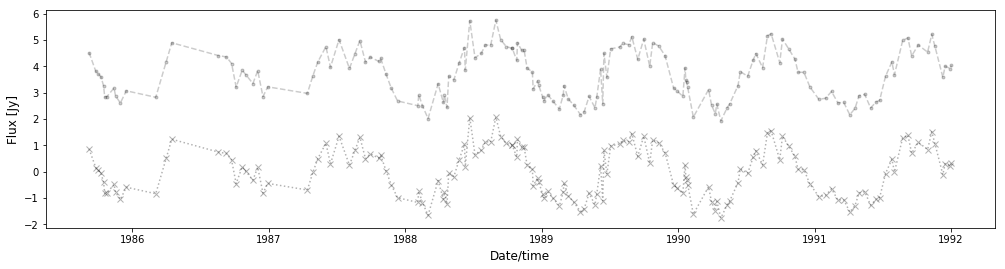

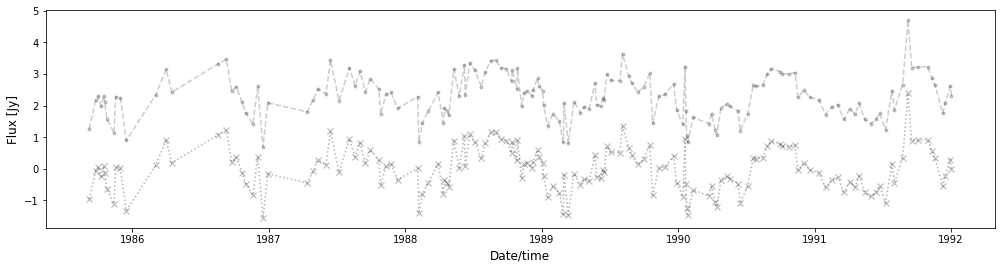

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
fig, ax = timeseries(ts_jd.datetime, spectra[:, 0],
                     color='k', marker='.', linestyle='--', alpha=0.2,
                     fig=fig, ax=ax)

fig, ax = timeseries(ts_jd.datetime, detrended_spectra[0, :],
                     color='k', marker='x', linestyle=':', alpha=0.3,
                     fig=fig, ax=ax)
ax.set_ylabel('Flux [Jy]', fontsize=12)
ax.set_xlabel('Date/time', fontsize=12)

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
fig, ax = timeseries(ts_jd.datetime, spectra[:, 1],
                     color='k', marker='.', linestyle='--', alpha=0.2,
                     fig=fig, ax=ax)

fig, ax = timeseries(ts_jd.datetime, detrended_spectra[, :],
                     color='k', marker='x', linestyle=':', alpha=0.3,
                     fig=fig, ax=ax)
ax.set_ylabel('Flux [Jy]', fontsize=12)
ax.set_xlabel('Date/time', fontsize=12)

plt.show()

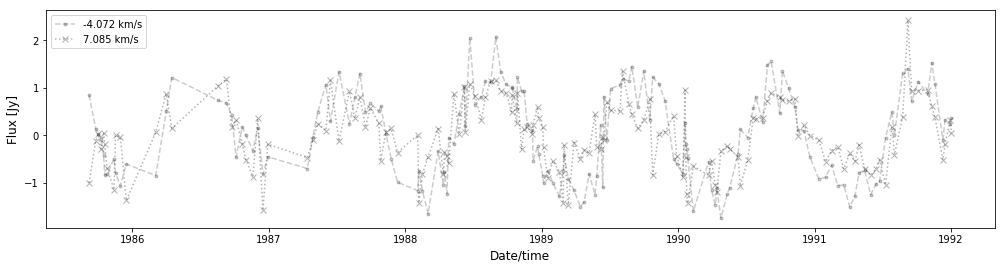

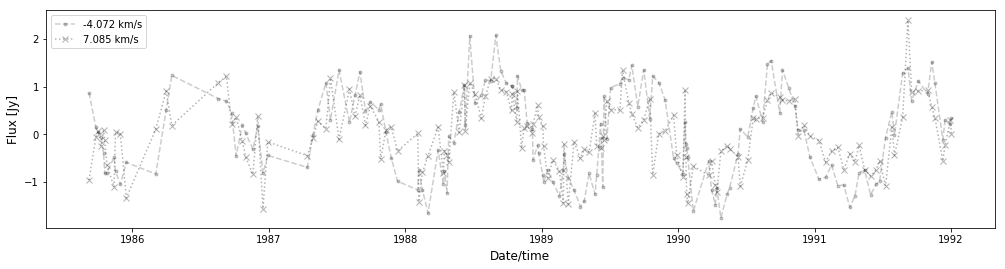

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
fig, ax = timeseries(ts_jd.datetime, spectra[:, 0]-np.mean(spectra[:, 0]),
                     color='k', marker='.', linestyle='--', alpha=0.2,
                     fig=fig, ax=ax)

fig, ax = timeseries(ts_jd.datetime, spectra[:, 1]-np.mean(spectra[:, 1]),
                     color='k', marker='x', linestyle=':', alpha=0.3,
                     fig=fig, ax=ax)

labels = ['{} km/s'.format(chan_vel[0]), '{} km/s'.format(chan_vel[1])] 
ax.set_ylabel('Flux [Jy]', fontsize=12)
ax.set_xlabel('Date/time', fontsize=12)
ax.legend(labels, loc=0)

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
fig, ax = timeseries(ts_jd.datetime, detrended_spectra[0, :],
                     color='k', marker='.', linestyle='--', alpha=0.2,
                     fig=fig, ax=ax)

fig, ax = timeseries(ts_jd.datetime, detrended_spectra[1, :],
                     color='k', marker='x', linestyle=':', alpha=0.3,
                     fig=fig, ax=ax)

labels = ['{} km/s'.format(chan_vel[0]), '{} km/s'.format(chan_vel[1])] 
ax.set_ylabel('Flux [Jy]', fontsize=12)
ax.set_xlabel('Date/time', fontsize=12)
ax.legend(labels, loc=0)

plt.show()

In [10]:
outfile = os.path.basename(filename)
[name, ext] = os.path.splitext(outfile)
outfile = '{}_detrended{}'.format(name, ext)

[comment, head_line] = header.strip().split('\n')
comment ='{}\n'.format(comment.strip())
comment += '{}, {:.3f}, {:.3f}\n'.format(head_line.split(',')[0], chan_vel[0], chan_vel[1])

io.output(outfile, comment, timestamps, detrended_spectra.T)